In [1]:
# Load packages
library(dplyr)
library(rmweather)
library(ranger)
library(ggplot2)
library(jsonlite)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [11]:
#This function takes as input 1 station and performs timeseries normalization 
# in selected chemicals. It returns a tibble df 

normalize <- function(basefolder,fname,normalization_vars) {
    data <- read.csv(
        paste(basefolder,"/",fname,sep=""),
        header = TRUE,
        encoding = "UTF-8"
    )
    data$date <- as.POSIXct(data$time,format="%Y-%m-%d")
    location <- unlist(strsplit(fname, "[.]csv"))[[1]]

    # return(data)
    
    indicators <- c('no2_ug_m3', 'pm10_ug_m3', 'pm25_ug_m3', 'o3_ug_m3')

    normalized_df = data.frame(matrix(NA, nrow = dim(data)[1]))
    names(normalized_df) <- "date"
    normalized_df$date <- data$date

    importances_df = data.frame(matrix(NA))
    names(importances_df) <- "variable"

    for (variable_to_normalize in indicators){
        
        if(!(variable_to_normalize %in% colnames(data))){
            # logging the missing variable
            print(paste("The variable ",variable_to_normalize," is not in the dataframe",fname))
            next
        }
                
        weather_data_prepared <- rmw_prepare_data(data,value = variable_to_normalize)
        
        list_normalised <- rmw_do_all(
            weather_data_prepared,
            variables = normalization_vars,
            n_trees = 350,
            n_samples = 1500,
            verbose = FALSE,
            replace = FALSE,
        )
        # Una vez lo de arriba este completado guardar el dataframe normalizado como csv
        normalized_var_df = list_normalised$normalised
        names(normalized_var_df) <- c("date",variable_to_normalize)
        var_importances_df <- rmw_model_importance(list_normalised$model, date_unix = FALSE)
        var_importances_df$indicator <- variable_to_normalize
        normalized_df = merge(normalized_df,normalized_var_df,by="date")
        importances_df = bind_rows(importances_df,var_importances_df)
        
    }
    # write the normalized dataframe to csv
    fname <- paste("../01-data/interim/normalized/",location,"-normalized.csv",sep="")
    write.csv(normalized_df,fname, row.names = FALSE)
    
    # Write the importances to csv
    importances_df <- importances_df[complete.cases(importances_df),]
    fname <- paste("../reports/rf_model_importances/",location,"-rf_importances.csv",sep="")
    write.csv(importances_df,fname, row.names = FALSE)

    print(paste("Dataframe on",location,"has been normalized and saved to csv",fname))
    return(normalized_df)
}

In [3]:
# By station
location_dfs_csv <- c(
    'pza_eliptica',
    'vallecas',
    'urb_embajada',
    'tres_olivos',
    'sanchinarro',
    'parque_del_retiro',
    'castellana',
    'pza_del_carmen',
    'pza_de_espana',
    'plaza_castilla',
    'juan_carlos_i',
    'villaverde',
    'moratalaz',
    'arturo_soria',
    'avda_ramon_y_cajal',
    'barajas_pueblo',
    'barrio_del_pilar',
    'farolillo',
    'mendez_alvaro',
    'cuatro_caminos',
    'el_pardo',
    'ensanche_de_vallecas',
    'escuelas_aguirre',
    'casa_de_campo'
)

weather_vars <- c(
    "date_unix",
    "u_wind_component_100m", "v_wind_component_100m", 
    "u_wind_component_10m", "v_wind_component_10m", 
    "temperature", "mean_sea_level_pressure", 
    "surface_pressure", "total_precipitation"
)

for (location in location_dfs_csv){
    #normalize each dataframe of air quality stations
    normalize(
        "../01-data/interim/aq_weather_by_station",
        paste("aq_weather_",location,".csv",sep=""),
        normalization_vars = weather_vars
    )
}

Normalization including the effect of traffic

In [17]:
location_dfs_csv <- c(
    'pza_eliptica',
    'vallecas',
    'urb_embajada',
    'tres_olivos',
    'sanchinarro',
    'castellana',
    'pza_del_carmen',
    'pza_de_espana',
    'plaza_castilla',
    'juan_carlos_i',
    'villaverde',
    'moratalaz',
    'arturo_soria',
    'avda_ramon_y_cajal',
    'barajas_pueblo',
    'barrio_del_pilar',
    'farolillo',
    'mendez_alvaro',
    'cuatro_caminos',
    'ensanche_de_vallecas',
    'escuelas_aguirre'
)

predictor_vars <- c(
    "date_unix",
    "u_wind_component_100m", "v_wind_component_100m", 
    "u_wind_component_10m", "v_wind_component_10m", 
    "temperature", "mean_sea_level_pressure", 
    "surface_pressure", "total_precipitation",
    "traffic_intensity","traffic_load"
)

for (location in location_dfs_csv){
    #normalize each dataframe of air quality stations
    normalize(
        "../01-data/interim/aq_weather_traffic_by_station",
        paste("aq_weather_traffic_",location,".csv",sep=""),
        normalization_vars = predictor_vars
    )
}

[1] "Dataframe on aq_weather_traffic_pza_eliptica has been normalized and saved to csv ../reports/rf_model_importances/aq_weather_traffic_pza_eliptica-rf_importances.csv"
[1] "The variable  pm25_ug_m3  is not in the dataframe aq_weather_traffic_vallecas.csv"
[1] "The variable  o3_ug_m3  is not in the dataframe aq_weather_traffic_vallecas.csv"
[1] "Dataframe on aq_weather_traffic_vallecas has been normalized and saved to csv ../reports/rf_model_importances/aq_weather_traffic_vallecas-rf_importances.csv"
[1] "The variable  pm25_ug_m3  is not in the dataframe aq_weather_traffic_urb_embajada.csv"
[1] "The variable  o3_ug_m3  is not in the dataframe aq_weather_traffic_urb_embajada.csv"
[1] "Dataframe on aq_weather_traffic_urb_embajada has been normalized and saved to csv ../reports/rf_model_importances/aq_weather_traffic_urb_embajada-rf_importances.csv"
[1] "The variable  pm25_ug_m3  is not in the dataframe aq_weather_traffic_tres_olivos.csv"
[1] "Dataframe on aq_weather_traffic_tres_olivos

In [15]:
dataset = paste("aq_weather_traffic_",location,sep="")
var_to_normalize = "no2_ug_m3"
indicators <- c('no2_ug_m3','no_ug_m3','co_ug_m3', 'pm10_ug_m3', 'pm25_ug_m3', 'o3_ug_m3','co_mg_m3')
weather_vars <- c(
    "day_julian","u_wind_component_100m", "v_wind_component_100m", 
    "u_wind_component_10m", "v_wind_component_10m", 
    "temperature", "mean_sea_level_pressure", 
    "surface_pressure", "total_precipitation"
)

data = read.csv(paste("../01-data/interim/aq_weather_traffic_by_station/",dataset,".csv",sep=""),header = TRUE)
data$date <- as.POSIXct(data$time,format="%Y-%m-%d")
data

Warning message in file(file, "rt"):
"cannot open file '../01-data/interim/aq_weather_traffic_by_station/aq_weather_traffic_el_pardo.csv': No such file or directory"


ERROR: Error in file(file, "rt"): cannot open the connection


In [10]:
location

[1] "vallecas"

#### **For 1 station (testing 1 chemical)**

In [8]:
dataset = "aq_weather_pza_de_espana"
var_to_normalize = "no2_ug_m3"
indicators <- c('no2_ug_m3','no_ug_m3','co_ug_m3', 'pm10_ug_m3', 'pm25_ug_m3', 'o3_ug_m3','co_mg_m3')
weather_vars <- c(
    "day_julian","u_wind_component_100m", "v_wind_component_100m", 
    "u_wind_component_10m", "v_wind_component_10m", 
    "temperature", "mean_sea_level_pressure", 
    "surface_pressure", "total_precipitation"
)

data = read.csv(paste("../01-data/interim/aq_weather_by_station/",dataset,".csv",sep=""),header = TRUE)
data$date <- as.POSIXct(data$time,format="%Y-%m-%d")
weather_data_prepared <- rmw_prepare_data(data,value = var_to_normalize)
list_normalised <- rmw_do_all(
    weather_data_prepared,
    variables = weather_vars,
    n_trees = 350,
    n_samples = 1000,
    verbose = FALSE,
    replace=FALSE
)

head(list_normalised$normalised)

,time,co_mg_m3,no2_ug_m3,no_ug_m3,nox_ug_m3,so2_ug_m3,u_wind_component_100m,v_wind_component_100m,u_wind_component_10m,v_wind_component_10m,temperature,mean_sea_level_pressure,surface_pressure,total_precipitation,date
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>
1,2014-01-01,0.2608696,30.95652,9.521739,45.60870,4.260870,3.540928,5.724899,1.8035136,3.398030,7.766250,101878.8,94411.63,7.505017e-05,2014-01-01
2,2014-01-02,0.2583333,36.00000,25.541667,75.16667,4.041667,5.129373,5.896095,2.8712908,3.715881,10.241233,101490.4,94105.12,2.990261e-04,2014-01-02
3,2014-01-03,0.2708333,37.08333,28.541667,80.83333,4.250000,4.455826,5.400601,2.4164256,3.355613,11.066160,101857.1,94463.54,3.464368e-04,2014-01-03
4,2014-01-04,0.2000000,23.12500,10.250000,38.91667,3.875000,7.983701,4.710279,4.6593887,3.099001,8.482114,101510.8,94075.99,5.953321e-04,2014-01-04
5,2014-01-05,0.2500000,32.41667,17.958333,60.12500,3.916667,3.935361,3.722770,2.1007145,2.423287,6.271772,102368.2,94813.25,3.008369e-06,2014-01-05
6,2014-01-06,0.2958333,45.20833,15.500000,68.62500,4.041667,2.101189,4.372871,0.9033737,2.520637,8.704730,102106.2,94638.59,1.802663e-05,2014-01-06


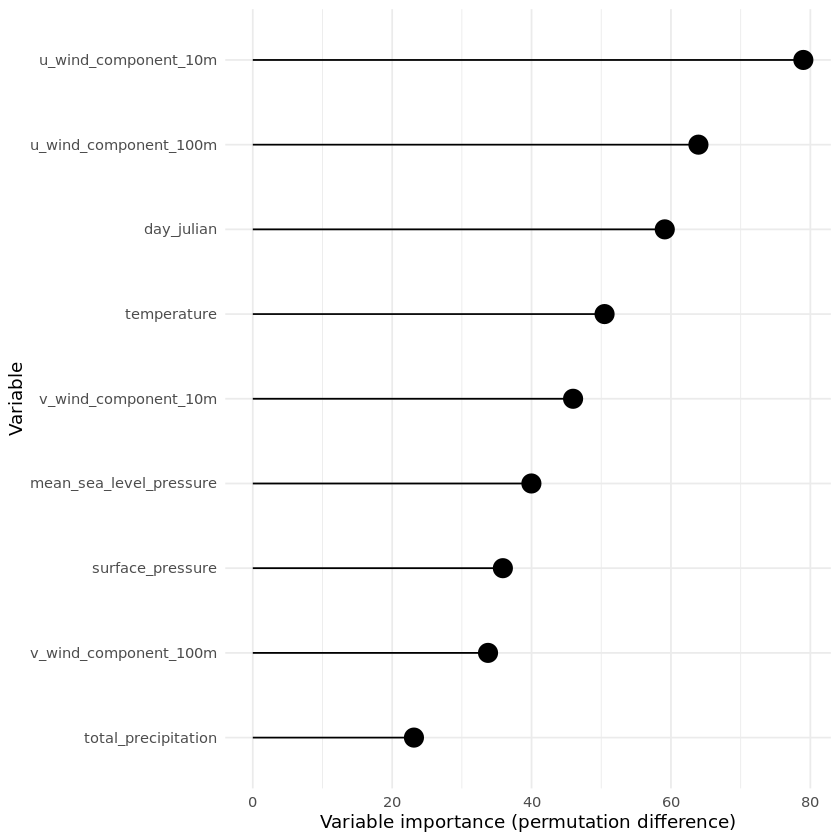

In [11]:
importances <- rmw_model_importance(list_normalised$model, date_unix = FALSE)
rmw_plot_importance(importances)

In [14]:
A <- data.frame(matrix(NA))
names(A) <- "variable"
df1 <- importances
df1$indicator <- "no2_ug_m3"
df2 <- importances
df2$indicator <- "no_ug_m3"
merged = bind_rows(A,df1,df2)
merged[complete.cases(merged),]

,variable,rank,importance,indicator
,<chr>,<int>,<dbl>,<chr>
2,u_wind_component_10m,1,78.99392,no2_ug_m3
3,u_wind_component_100m,2,63.94091,no2_ug_m3
4,day_julian,3,59.11300,no2_ug_m3
5,temperature,4,50.47306,no2_ug_m3
6,v_wind_component_10m,5,45.95723,no2_ug_m3
7,mean_sea_level_pressure,6,39.97594,no2_ug_m3
8,surface_pressure,7,35.88356,no2_ug_m3
9,v_wind_component_100m,8,33.75380,no2_ug_m3
10,total_precipitation,9,23.12514,no2_ug_m3


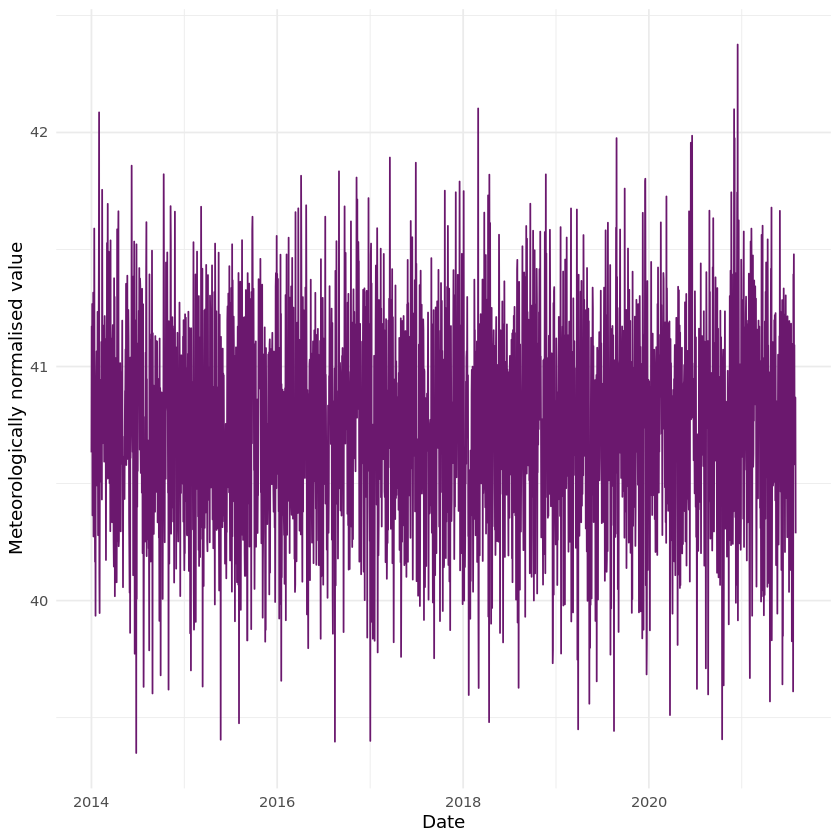

In [15]:
rmw_plot_normalised(list_normalised$normalised)